#revie experiments

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
import sys
from PIL import Image
sys.path.insert(1, '/its/home/drs25/Documents/GitHub/Quadruped/Code')
sys.path.insert(1, 'C:/Users/dexte/Documents/GitHub/Quadruped/Code')
from CPG import *
datapath="/its/home/drs25/Documents/GitHub/Quadruped/"
datapath="C:/Users/dexte/Documents/GitHub/Quadruped/"

## load in data

### dt

In [10]:
best_CPGs=[]
fitnesses=[]
trials=2
for _ in range(1,trials+1):
    for dt in np.arange(0.05,1.5,0.05):
        filename = datapath+'/models/genotypes_dt'+str(dt)+"_"+str(_)
        population=None
        with open(filename+'.pkl', 'rb') as f:
            population = pickle.load(f)
        f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
        best_geno=np.argmax(f_)
        best_CPGs=population[best_geno]
        fitnesses.append(np.max(f_))

fitnesses=np.array(fitnesses).reshape(len(np.arange(0.05,1.5,0.05)),trials).T
print(fitnesses.shape)


(2, 29)


#### average dt

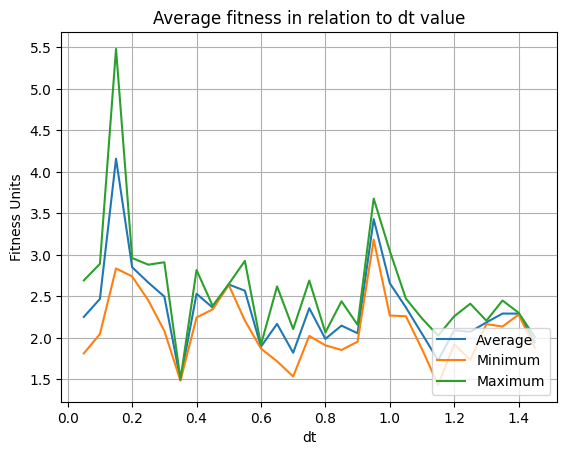

In [12]:
size=len(np.arange(0.05,1.5,0.05))
plt.plot(np.arange(0.05,1.5,0.05),np.average(fitnesses,axis=0),label="Average")
plt.plot(np.arange(0.05,1.5,0.05),np.min(fitnesses,axis=0),label="Minimum")
plt.plot(np.arange(0.05,1.5,0.05),np.max(fitnesses,axis=0),label="Maximum")
plt.xlabel("dt")
plt.ylabel("Fitness Units")
plt.title("Average fitness in relation to dt value")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### trials

(20,) [1.87518805 2.05244644 2.88701113 2.34787167 1.93686972 2.01408603
 3.11433648 1.84133949 1.65930578 5.54943988 2.30737154 2.37057806
 1.61738329 1.81105148 2.2444781  2.55588968 1.91071911 1.91959189
 3.15463089 1.94462   ] (20, 240)


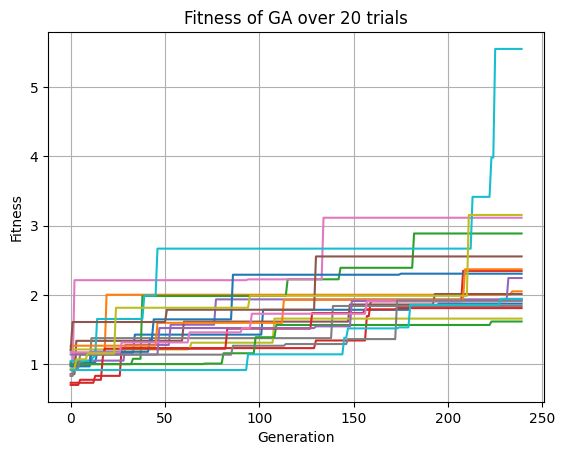

In [12]:
best_CPGs=[]
fitnesses=[]
history=[]
trials=20
dt=0.1
for _ in range(trials):
    filename = datapath+'/models/genotypes_dt'+str(dt)+"_6_neurons_"+str(_)
    population=None
    with open(filename+'.pkl', 'rb') as f:
        population = pickle.load(f)
    f_=np.load((filename+'.npy').replace("genotypes","fitnesses"))
    history.append(np.load((filename+'.npy').replace("genotypes","history")))
    best_geno=np.argmax(f_)
    best_CPGs=population[best_geno]
    fitnesses.append(np.max(f_))

fitnesses=np.array(fitnesses).reshape(trials)
history=np.array(history)[:,:-10]
print(fitnesses.shape,fitnesses,history.shape)
plt.plot(history.T)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.grid(True)
plt.show()

#### average trials

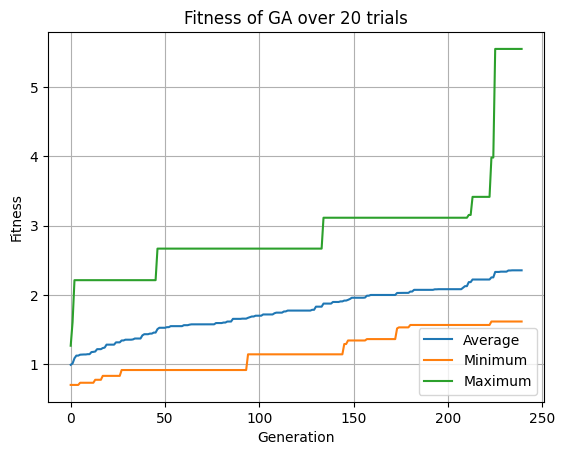

In [10]:

plt.plot(np.average(history,axis=0),label="Average")
plt.plot(np.min(history,axis=0),label="Minimum")
plt.plot(np.max(history,axis=0),label="Maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness of GA over 20 trials")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Display images

(5, 480, 640, 4)


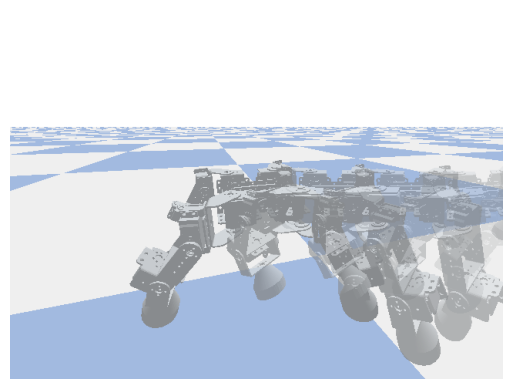

In [55]:

#write function that removes everything but robot
def remove_back(image,alpha=0):
    remove_colors = [(255, 255, 255), (162, 186, 224), (239, 239, 239)]
    image_pix = image[:, :, :3]  # Extract RGB channels
    # Ensure the image has an alpha channel
    if image.shape[2] == 3:
        image = np.dstack((image, np.full(image.shape[:2], 255, dtype=np.uint8)))  # Add alpha channel
    for color in remove_colors:
        mask = np.all(image_pix == color, axis=-1)
        image[mask]=0
        image[mask, 3] = alpha  # Set alpha to 0 (fully transparent) for matching colors
    return image
def change_robot_vis(image,alpha=0):
    image_pix = image[:, :, :3]  # Extract RGB channels
    # Ensure the image has an alpha channel
    if image.shape[2] == 3:
        image = np.dstack((image, np.full(image.shape[:2], 255, dtype=np.uint8)))  # Add alpha channel
    mask = np.all(image_pix != (0,0,0), axis=-1)
    image[mask, 3] = alpha  # Set alpha to 0 (fully transparent) for matching colors
    return image

def overlay_images_shifted(images, shift=100):
    base = images[0].astype(np.float32)
    h, w = base.shape[:2]

    for i, overlay in enumerate(images[1:], start=1):
        overlay = change_robot_vis(remove_back(overlay,0),(len(images)-i)/len(images) *255)
        #overlay[:,:,3]=0#(len(images)-i)/len(images) *100
        overlay = overlay.astype(np.float32)
        overlay = cv2.resize(overlay, (w, h), interpolation=cv2.INTER_LANCZOS4) if overlay.shape[:2] != (h, w) else overlay
        shift_x = min(i * shift, w)  # Ensure shifting doesn't exceed width
        shifted_overlay = np.zeros_like(base)

        if overlay.shape[-1] == 4:
            shifted_overlay[:, shift_x:] = overlay[:, :w - shift_x]  # Shift right
        else:
            shifted_overlay[:, shift_x:, :3] = overlay[:, :w - shift_x, :3]  # Shift RGB
            shifted_overlay[:, shift_x:, 3:4] = 255  # Full alpha

        alpha_overlay = shifted_overlay[..., 3:4] / 255.0
        alpha_base = base[..., 3:4] / 255.0
        blended_rgb = shifted_overlay[..., :3] * alpha_overlay + base[..., :3] * (1 - alpha_overlay)
        blended_alpha = alpha_overlay + alpha_base * (1 - alpha_overlay)
        base = np.concatenate([blended_rgb, blended_alpha * 255], axis=-1)

    return base.astype(np.uint8)

images=np.load(datapath+"/assets/frames.npy")[0:5]
print(images.shape)
image=overlay_images_shifted(images)
output_image = Image.fromarray(image)
output_image.save(datapath+"/assets/robot.png", format="PNG")
plt.imshow(image)
plt.axis("off")
plt.show()

